In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import itertools
import os
import json
import os.path as osp
%cd ..

/scratch/yz10381/CODES/accediff


/scratch/yz10381/miniconda3/envs/diffusers/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


All exp are conducted on one H100

In [2]:
def read_from_dir(dir_path, data_name, model_name):
    exps = []
    for subdir in os.listdir(dir_path):
        subdir_path = osp.join(dir_path, subdir, 'benchmark_image_generation')
        image_fild_score_log_path = osp.join(subdir_path, 'image_fid_score_evaluation.log')
        image_clip_score_log_path = osp.join(subdir_path, 'image_clip_score_evaluation.log')
        generation_log_path = osp.join(subdir_path, 'text_to_image_generation.log')

        # read : 2024-12-05 19:32:02,322 - __main__ - INFO - Average CLIP Score: 20.951017379760742
        for line in open(image_clip_score_log_path):
            if "Average CLIP Score" in line:
                clip_score = float(line.split(":")[-1].strip())
                break
        
        # read : 2024-12-05 19:41:59,625 - __main__ - INFO - FID Score: 344.50787353515625
        for line in open(image_fild_score_log_path):
            if "FID Score" in line:
                fid_score = float(line.split(":")[-1].strip())
                break
        
        # read : 2024-12-05 16:55:17,154 - __main__ - INFO - Total time: 68.27094841003418 seconds for 97 iterations, throughput: 1.420809323131409 iterations/second
        for line in open(generation_log_path):
            if "Total time:" in line:
                throughput = float(line.split()[-2])
                break
        
        exps.append({
            "data_name": data_name,
            "model_name": model_name,
            "throughput": throughput,
            "clip_score": clip_score,
            "fid_score": fid_score,
        })
    return exps

In [3]:
read_kwargs = [
    {
        "dir_path": "RESULTS/coco_cc12m_no_cfg",
        "data_name": "coco",
        "model_name": "cc12m"
    },
    {
        "dir_path": "RESULTS/coco_finetuned_20_no_cfg",
        "data_name": "coco",
        "model_name": "finetuned_20"
    },
    {
        "dir_path": "RESULTS/coco_finetuned_40_no_cfg",
        "data_name": "coco",
        "model_name": "finetuned_40"
    },
    {
        "dir_path": "RESULTS/coco_midjv6_no_cfg",
        "data_name": "coco",
        "model_name": "midjv6"
    },
    {
        "dir_path": "RESULTS/coco_origin_baseline_no_cfg",
        "data_name": "coco",
        "model_name": "baseline"
    },
    {
        "dir_path": "RESULTS/coco_origin_baseline_no_cfg",
        "data_name": "coco",
        "model_name": "baseline-no-cfg"
    },
    {
        "dir_path": "RESULTS/coco_origin_baseline_cfg",
        "data_name": "coco",
        "model_name": "baseline-cfg"
    },
    {
        "dir_path": "RESULTS/midjv6_cc12m_no_cfg",
        "data_name": "midjv6",
        "model_name": "cc12m"
    },
    {
        "dir_path": "RESULTS/midjv6_finetuned_20_no_cfg",
        "data_name": "midjv6",
        "model_name": "finetuned_20"
    },
    {
        "dir_path": "RESULTS/midjv6_finetuned_40_no_cfg",
        "data_name": "midjv6",
        "model_name": "finetuned_40"
    },
    {
        "dir_path": "RESULTS/midjv6_midjv6_no_cfg",
        "data_name": "midjv6",
        "model_name": "midjv6"
    },
    {
        "dir_path": "RESULTS/midjv6_origin_baseline_no_cfg",
        "data_name": "midjv6",
        "model_name": "baseline-no-cfg"
    },
    {
        "dir_path": "RESULTS/midjv6_origin_baseline_cfg",
        "data_name": "midjv6",
        "model_name": "baseline-cfg"
    },
]

In [4]:
datas = sum([read_from_dir(**kwargs) for kwargs in read_kwargs], [])

In [5]:
datas

[{'data_name': 'coco',
  'model_name': 'cc12m',
  'throughput': 0.2824918940399879,
  'clip_score': 30.324312210083008,
  'fid_score': 196.2346954345703},
 {'data_name': 'coco',
  'model_name': 'cc12m',
  'throughput': 0.14590485384066298,
  'clip_score': 30.24542808532715,
  'fid_score': 197.0455322265625},
 {'data_name': 'coco',
  'model_name': 'cc12m',
  'throughput': 0.9394467559392821,
  'clip_score': 30.56787872314453,
  'fid_score': 196.1805419921875},
 {'data_name': 'coco',
  'model_name': 'cc12m',
  'throughput': 2.2433348695185455,
  'clip_score': 24.3411808013916,
  'fid_score': 351.1531982421875},
 {'data_name': 'coco',
  'model_name': 'cc12m',
  'throughput': 1.5342705493314923,
  'clip_score': 29.969816207885742,
  'fid_score': 225.69613647460938},
 {'data_name': 'coco',
  'model_name': 'cc12m',
  'throughput': 0.5294885333425725,
  'clip_score': 30.576438903808594,
  'fid_score': 196.50294494628906},
 {'data_name': 'coco',
  'model_name': 'finetuned_20',
  'throughput': 

In [ ]:
def plot(datas, group_by_fn, select_fn=lambda x: True, group_to_label_fn=lambda x: str(x)):
    title2datas = defaultdict(list)
    for data in datas:
        if select_fn(data):
            title2datas[group_by_fn(data)].append(data)
    
    # plot throughput -- clip score
    fig, ax = plt.subplots()
    for title, datas in title2datas.items():
        throughputs = [data["throughput"] for data in datas]
        clip_scores = [data["clip_score"] for data in datas]
        sort_index = sorted(range(len(throughputs)), key=lambda k: throughputs[k])
        throughputs = [throughputs[i] for i in sort_index]
        clip_scores = [clip_scores[i] for i in sort_index]
        ax.plot(throughputs, clip_scores, label=group_to_label_fn(title))
    
    ax.set_xlabel("Throughput (images/sec)")
    ax.set_ylabel("Clip Score")
    ax.legend()
    ax.set_title(f"Throughput -- Clip Score")
    plt.show()

    # plot throughput -- fid score
    fig, ax = plt.subplots()
    for title, datas in title2datas.items():
        throughputs = [data["throughput"] for data in datas]
        fid_scores = [data["fid_score"] for data in datas]
        sort_index = sorted(range(len(throughputs)), key=lambda k: throughputs[k])
        throughputs = [throughputs[i] for i in sort_index]
        fid_scores = [fid_scores[i] for i in sort_index]
        ax.plot(throughputs, fid_scores, label=group_to_label_fn(title))
    ax.set_xlabel("Throughput (images/sec)")
    ax.set_ylabel("FID Score")
    ax.legend()
    ax.set_title(title)
    plt.show()


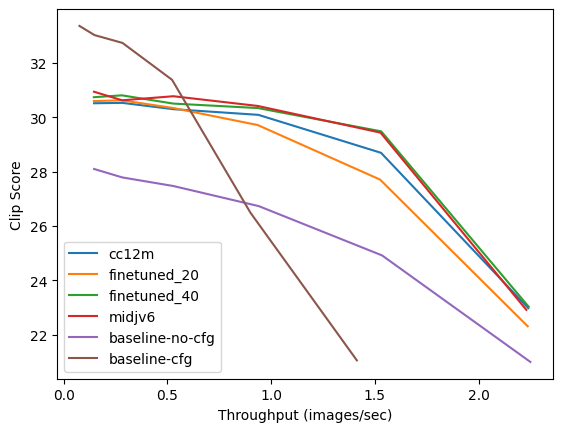

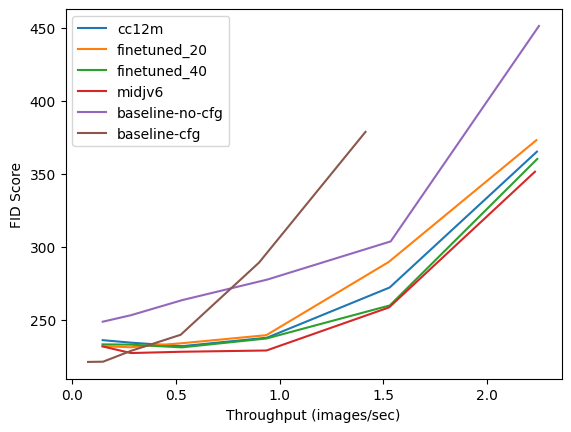

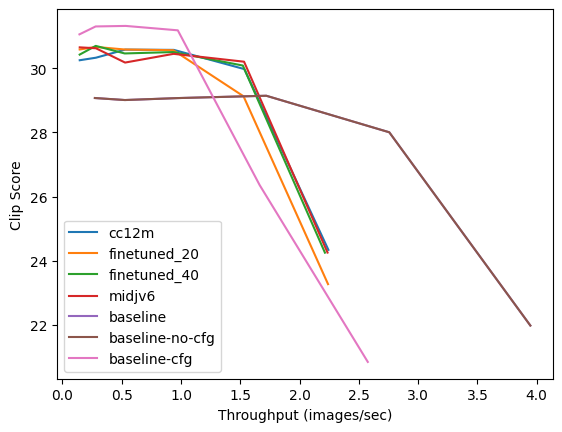

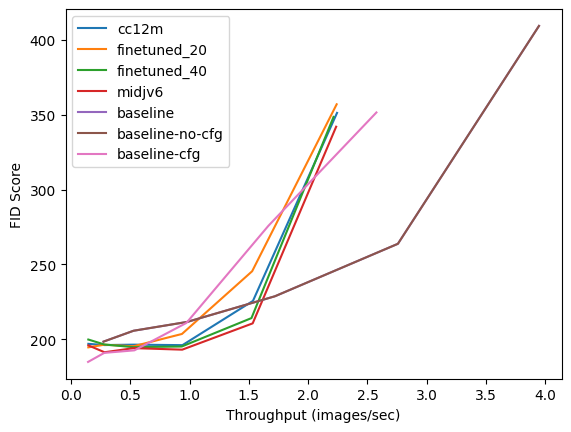

In [14]:
plot(
    datas,
    group_by_fn=lambda data: (data["data_name"], data["model_name"]),
    select_fn=lambda data: data["data_name"] == "midjv6",
    group_to_label_fn=lambda x: x[1]   
)

plot(
    datas,
    group_by_fn=lambda data: (data["data_name"], data["model_name"]),
    select_fn=lambda data: data["data_name"] == "coco",
    group_to_label_fn=lambda x: x[1]   
)